In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
import cartopy.crs as ccrs

In [2]:
file_path='/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5/'
ds_fluxes=xr.open_dataset(file_path+'01810101.ocean_minibling_surf_flux.nc', chunks={"time": 10})[['o2_stf', 'dic_stf']]*60*60*24*365
ds_ssh_sst=xr.open_dataset(file_path+'01810101.ice_daily.nc', chunks={"time": 10})[['SSH', 'SST']]
ds_heat=xr.open_dataset(file_path+'01810101.ocean_bdy_flux.nc', chunks={"time": 10})[['sens_heat', 'evap_heat']]

In [ ]:
###Model Output corrected ice data in one ds

ds_ssh_sst=ds_ssh_sst.assign_coords({'xt': (ds_fluxes.xt_ocean.data), 
                                       'yt': (ds_fluxes.yt_ocean.data)})
ds_ssh_sst=ds_ssh_sst.rename({'xt': 'xt_ocean', 'yt': 'yt_ocean'})

ds_old=xr.merge([ds_fluxes, ds_ssh_sst])
ds_old.to_netcdf('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/MOM5_daily.nc')

In [3]:
def Boxfilter(data, size=30):
    #10 spatial steps by default
    kernel = Box2DKernel(size)
    #wrap assumes periodic boundaries
    conv=convolve(data, kernel, boundary='wrap')
    conv=data.copy(data=conv)
    return conv

In [4]:
def Data_3D(data):
    res=[]
    for date in data.time:
        conv=Boxfilter(data.sel(time=date), size=30)
        res.append(conv)
    da_res=xr.concat(res, dim='time')
    return da_res

# testing

In [5]:
ssh_test=ds_ssh_sst.SSH.isel(time=0)
agulhas_ssh=ssh_test.sel(xt=slice(-20,70)).sel(yt=slice(-70,-0))

sst_test=ds_ssh_sst.SST.isel(time=0)
agulhas_sst=sst_test.sel(xt=slice(-20,70)).sel(yt=slice(-70,-0))

In [6]:
box55_ssh=Boxfilter(agulhas_ssh, size=50)
box33_ssh=Boxfilter(agulhas_ssh, size=30)

box55_sst=Boxfilter(agulhas_sst, size=50)
box33_sst=Boxfilter(agulhas_sst, size=30)

In [7]:
#cropping
agulhas_ssh=agulhas_ssh.sel(xt=slice(0,50), yt=slice(-45,-30))
box55_ssh=box55_ssh.sel(xt=slice(0,50), yt=slice(-45,-30))
box33_ssh=box33_ssh.sel(xt=slice(0,50), yt=slice(-45,-30))

agulhas_sst=agulhas_sst.sel(xt=slice(0,50), yt=slice(-45,-30))
box55_sst=box55_sst.sel(xt=slice(0,50), yt=slice(-45,-30))
box33_sst=box33_sst.sel(xt=slice(0,50), yt=slice(-45,-30))

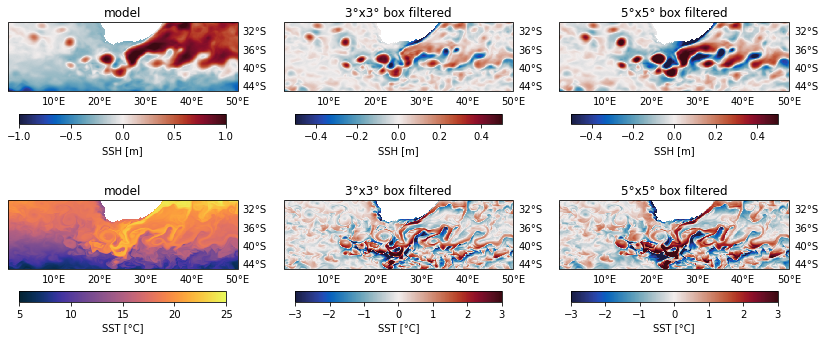

In [13]:
data=[agulhas_ssh, (agulhas_ssh-box33_ssh),  (agulhas_ssh-box55_ssh), agulhas_sst, (agulhas_sst-box33_sst),  (agulhas_sst-box55_sst)]
title=['model', '3°x3° box filtered', '5°x5° box filtered', 'model', '3°x3° box filtered', '5°x5° box filtered']
fig = plt.figure(figsize=(14,6))
for i in range(1,4):
    var=data[i-1]
    ax = plt.subplot(2,3,i, projection=ccrs.PlateCarree())
    vmin, vmax=(-.5, .5)
    cmap=cmo.balance
    if i==1:
        vmin, vmax=(-1, 1)
        cmap=cmo.balance
    p = ax.pcolormesh(var.xt,var.yt,var,cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
    cbar = plt.colorbar(p, shrink=0.9, orientation="horizontal", label='SSH [m]') 
    ax.set_title(title[i-1])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    ax.yaxis.tick_right()
    #ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
for i in range(4,7):
    var=data[i-1]
    ax = plt.subplot(2,3,i, projection=ccrs.PlateCarree())

    vmin, vmax=(-3, 3)
    cmap=cmo.balance
    if i==4:
        vmin, vmax=(5, 25)
        cmap=cmo.thermal
    p = ax.pcolormesh(var.xt,var.yt,var,cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
    cbar = plt.colorbar(p, shrink=0.9, orientation="horizontal", label='SST [°C]') 
    ax.set_title(title[i-1])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    ax.yaxis.tick_right()

plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/testing/3x3vs5x5_boxcar_agulhas_ssh_sst.png', dpi=300)

# create filtered datasets

In [ ]:
sst=Data_3D(ds_old.SST)
ssh=Data_3D(ds_old.SSH)
o2=Data_3D(ds_old.o2_stf)
dic=Data_3D(ds_old.dic_stf)

##we don't have daily data of sens_heat and evap_heat

###need to save each variable in a single file because files too large
ds_daily=xr.merge([o2])
ds_daily.to_netcdf('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/vars/3x3_boxfilter_daily_o2.nc')

### merge together

In [20]:
#filtered data in one file
ds=xr.open_mfdataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/vars/*.nc')
ds
ds.to_netcdf('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_daily.nc') ###eventuell neustarten

### anomaly

In [4]:
ds_old= xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/MOM5_daily.nc', chunks={"time": 10})
ds=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_daily.nc', chunks={"time": 10})

In [5]:
ds_ano=ds_old-ds

In [7]:
ds_ano.to_netcdf('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_anomaly_daily.nc')

## linear regression

In [52]:
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/'
dsa=xr.open_dataset(pathf+'3x3_boxfilter_anomaly_daily.nc', chunks={"xt_ocean": 10, "yt_ocean":10})

In [53]:
o2=dsa.o2_stf
dic=dsa.dic_stf
ssh=dsa.SSH
sst=dsa.SST

In [ ]:
###!!!!takes some time
ssh_sst=xr.corr(ssh, sst, dim='time').compute()
sst_o2=xr.corr(sst, o2, dim='time').compute()
sst_dic=xr.corr(sst, dic, dim='time').compute()

In [ ]:
### save correlation maps, because it takes a while to compute
correlations=[ssh_sst,sst_o2, sst_dic]
correlations.to_netcdf('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_sst_correlations_daily.nc')